# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

Depending on how the data is presented, it could be both. For example, if the labels were given as binary output (passed vs failed), this would clearly be a classification problem. On the other hand, if we were given numerical data as labels (for example, the final grade of the student), we could also consider this as a regression problem. If this were the case, we would have to determine a passed/failed threshold (6/10, for example), estimate the final grade of the student and see if it's above or below that threshold. 

**This said, I believe classification would be more appropriate for this kind of problem**, since it gives a more straightforward answer to our question: if the student continues with his/her current performance, will he/she pass or fail?

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
from IPython.display import Image

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
df_shape = student_data.shape

# TODO: Calculate number of students
n_students = df_shape[0]

# TODO: Calculate number of features (subtract the target column)
n_features = df_shape[1] - 1

# TODO: Calculate passing students
n_passed = student_data[student_data['passed']=='yes'].count()['passed']

# TODO: Calculate failing students
n_failed = student_data[student_data['passed']=='no'].count()['passed']

# TODO: Calculate graduation rate
grad_rate = float(n_passed)/float(n_students) * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
# Using stratification since the data is slightly unbalanced
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify = y_all, train_size=num_train, random_state=10)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. What are the general applications of each model? What are their strengths and weaknesses? Given what you know about the data, why did you choose these models to be applied?*

**Answer: **

Three supervised learning models appropriate for this problem are: 
- Decision Trees
- Support Vector Machines
- Naive Bayes


###### DECISION TREES:
- General applications:
    - Decision trees can be used for both classification and regression problems, by creating a series of simple rules that can be visualized as a tree. We saw one possible use a few exercises ago, when we were predicting the probability of a given person of surviving the Titanic. 
- Strengths:
    - Decision trees are easy to visualize and interpret.
    - Require little data preparation, since it can handle datasets that have errors or missing values.
    - Decision trees are able to handle both numerical and categorical data. 
    - The cost of running a tree is logarithmic in the number of data points used to train the tree.
- Weaknesses: 
    - Trees can create complex hypothesis that do not generalize well (overfit). In the examples below, we can see that all the F1 score for the train data (untuned model) is always 1. 
    - Decision trees can be unstable: new information or features could result in very different tree and predictions.
    - It’s possible to create biased trees if some classes dominate. 
    
    
###### SUPPORT VECTOR MACHINES:
- General applications:
    - Support vector machines can be used for classification, regression, and outlier detection. SVMs have been used in text categorization, image recognition, character recognition, etc. 
- Strengths: 
    - Though the use of the kernel trick, SVMs are effective in high dimensional spaces.
    - SVMs are versatile since they enable the use of different kernels. 
    - SVMs are useful in cases where the number of features is greater than the number of samples. 
    - SVMs only use a subset of training points in the decision function (maximizing the margin), making it memory efficient. 
- Weaknesses:
    - Because it requires de use of quadratic programming in large-scales tasks, SMSs can have a high algorithmic complexity and extensive memory requirements. 
    - SVMs will give poor performance if the number of features is much greater than the number of samples. 
    - SMVs do not directly provide probability estimates.
    

###### NAIVE BAYES:
- General applications:
    - Naive Bayes is a probabilistic classifier based on the assumption of independence between features. Naive Bayes has been used in document classification (for example, if a text belongs to sports, political, entertainment category, etc.), spam filtering, and medical diagnosis, among other.  
- Strengths:
    - Require small amount of training data to produce a prediction. 
    - Can be extremely fast compared to other, more sophisticated methods. 
    - Enables each distribution to be estimated independently, helping to mitigate the curse of dimensionality. 
- Weaknesses:
    - Even when it's considered as a good classifier, its probability estimates are not completely accurate. 
    - By default Naive Bayes assumes independence between features, something that may not be entirely true. 
    
    
    
** The models mentioned above are all appropriate for this problem because:**
- The dataset is relatively small (less than 400 samples), and all the algorithms selected here are known to work well even with small datasets. 
- The school wants to implement an effective model that has a small computational cost, and the three algorithms chosen above are memory efficient, do not require a large setup/preparation cost, and have relatively small running costs. 
- The of the weaknesses of the algorithms can be mitigated in some form or another, or simply do not apply, for example: 
    - Decision trees are prone overfit, but to avoid this problem we can increase the number of samples that the algorithm needs to make a split. 
    - SVMs do not work well if the number of samples is smaller than the number of features, which is not our case (395 samples vs 30 features). 
    - Naive Bayes is a good classifier, but we can't completely "trust" the probability estimates. In this case, we really don't care about the specific estimates, we just need to understand if the student is more likely to pass or fail. 
- This is a supervised learning / classification problem, so regression models (to estimate continuous outputs) or unsupervised learning algorithms (like clustering) are not appropriate. 



Sources of information:
- http://scikit-learn.org/stable/modules/tree.html
- http://www.ise.bgu.ac.il/faculty/liorr/hbchap9.pdf
- https://en.wikipedia.org/wiki/Support_vector_machine
- http://scikit-learn.org/stable/modules/svm.html
- http://www.svms.org/advantages.html
- http://www.svms.org/disadvantages.html
- https://en.wikipedia.org/wiki/Naive_Bayes_classifier
- http://scikit-learn.org/stable/modules/naive_bayes.html
- https://www.researchgate.net/post/What_are_the_disadvantages_of_Naive_Bayes



### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [7]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_tree = DecisionTreeClassifier(random_state=10)
clf_svc = SVC(random_state=10)
clf_bayes = GaussianNB()

# TODO: Set up the training set sizes
# TODO: Execute the 'train_predict' function for each classifier and each training set size

for clf in [clf_tree, clf_svc, clf_bayes]:
    for n in [100, 200, 300]:
        print "\n"
        train_predict(clf, X_train[:n],  y_train[:n], X_test, y_test)
        



Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0030 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0004 seconds.
F1 score for test set: 0.7188.


Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0015 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.7538.


Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0025 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.7910.


Training a SVC using a training set size of 100. . .
Trained model in 0.0016 seconds
Made predictions in 0.0009 seconds.
F1 score for training set: 0.8375.
Made predictions in 0.0012 seconds.
F1 score for test set: 0.7975.


Training a SVC using a training set size 

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - DecisionTreeClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0030          |         0.0004         |      1.0000      |     0.7188      |
| 200               |         0.0015          |         0.0002         |      1.0000      |     0.7538      |
| 300               |         0.0025          |         0.0002         |      1.0000      |     0.7910      |

** Classifer 2 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0016          |         0.0012         |      0.8375      |     0.7975      |
| 200               |         0.0041          |         0.0016         |      0.8750      |     0.7895      |
| 300               |         0.0103          |         0.0023         |      0.8602      |     0.8212      |

** Classifer 3 - GaussianNB**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0010          |         0.0005         |      0.8467      |     0.7538      |
| 200               |         0.0010          |         0.0003         |      0.8205      |     0.7576      |
| 300               |         0.0012          |         0.0004         |      0.8106      |     0.7786      |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Chosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

The model that I choose is Support Vector Machines. This model is appropriate for the following reasons: 
- SVMs are considered a good classification model because of its effectiveness and versatility. 
- It's memory efficient. The boundary that is drawn to separate our classes only takes into account those data points that contribute to maximize the margin of the hyperplane. 
- SVMs are known to generalize well, something that can be appreciated in the table above, where the F1 Score for training and testing remain very close to each other even when the training set size changes. 

Models can be appropriate or not depending on the particular situation. For example, if the available data and resources are limited, Naive Bayes can still produce satisfying results. If we want to improve accuracy by building a more sophisticated algorithm, neural networks would be the way to go. Finally, regarding performance... it really depends on what performance means to us. It could mean we want to reduce our training time, in which case something like k-nearest neighbors could be a good alternative. Overall, SVMs can provide a good balance based on the available data, limited resources, cost and performance.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. For example if you've chosen to use a decision tree or a support vector machine, how does the model go about making a prediction?*

**Answer: **

Support vector machines work by drawing a line that best separates the data points in each of the classes, in our case, students that passed and students that failed. This line is called the boundary or hyperplane. 

To draw this boundary, SVMs take into account only the most relevant points, which are the ones closest to this boundary, and tries to maximize the distance between the points in each class to this boundary. This distance is also called margin. Points that are far away from this boundary are given less weight or simply ignored, making this algorithm efficient compared to other algorithms that take into account all data points to make predictions. 

In order to generalize well, or avoid overfitting, SVMs will have to make some difficult choices, specifically misclassifying a few training points to avoid drawing very complicated boundaries. SVMs will try to choose the hypothesis that **maximizes the margin** and **minimizes the data points it classifies incorrectly**. 

There are some cases in which the data of different classes are not linearly separable. For example, this would be the case in which all of the data points of class A are located in the center, and the data points of class B are located all around class A. In this cases, SVMs apply a very interesting concept called the "kernel trick", by which the data is analyzed in a higher dimension, enabling it to draw more complicated boundaries to separate the data correctly, like in the image below. 

Predictions are made by “observing” where new data points fall in relation to this boundary.

Image: http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html


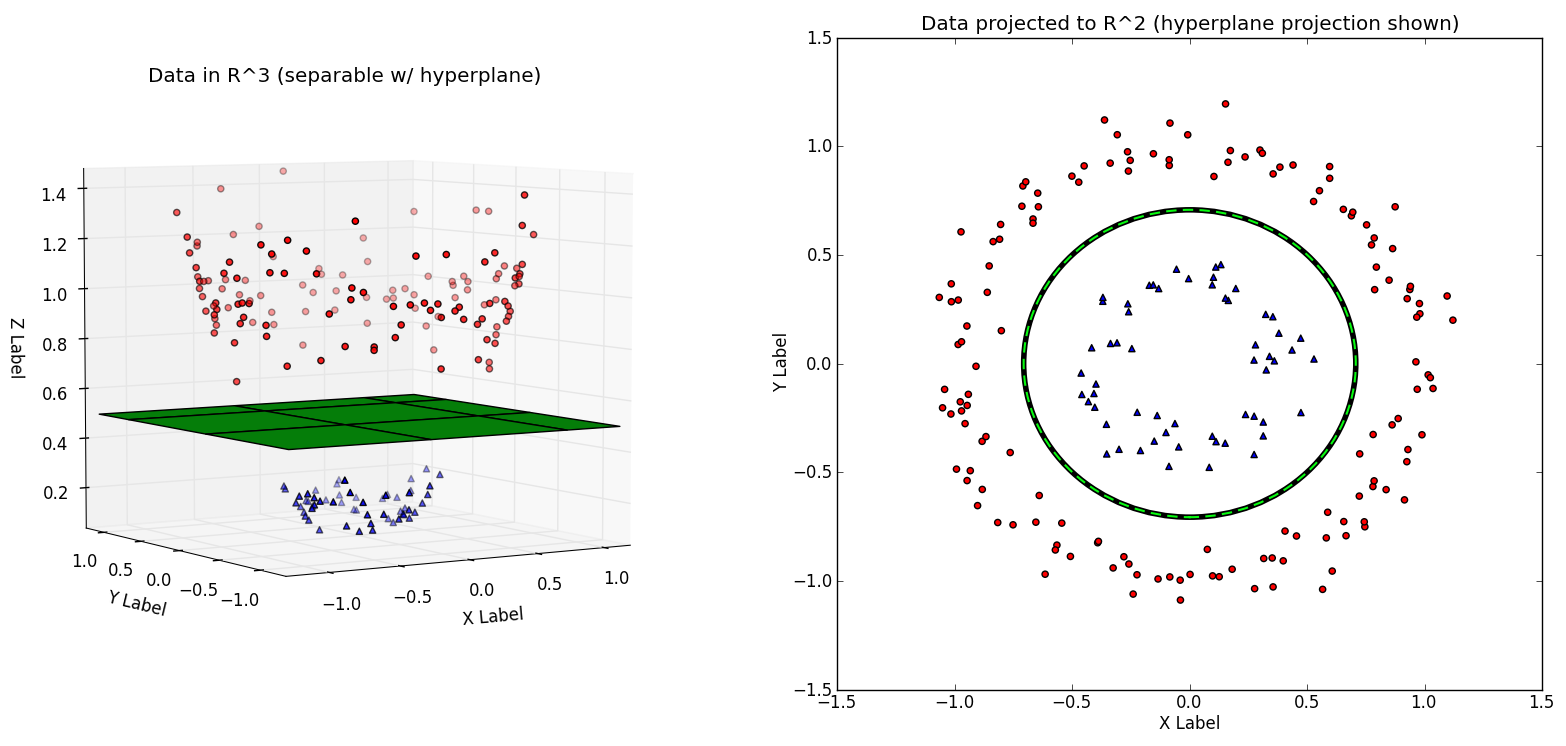

In [8]:
Image('data_2d_to_3d_hyperplane.png')

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [12]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {'kernel': ['linear', 'poly', 'rbf'],
             'C': [0.5, 1.0, 2.0, 10],
             'degree': [1, 2, 3, 4]}

# TODO: Initialize the classifier
clf = SVC(random_state=10)

# Build a stratified suffle object
ssscv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.1)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, cv=ssscv, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0043 seconds.
Tuned model has a training F1 score of 0.8253.
Made predictions in 0.0017 seconds.
Tuned model has a testing F1 score of 0.8235.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

With GridSearch, the F1 score for SVM for training is 0.8253, while the F1 score for testing is 0.8235. Compared to the untuned SVM, the F1 score was reduced for the training set (before it was 0.8602), but slightly increased for the testing set (before it was 0.8212). This means that our model is now more robust as it is able to better generalize to new data points. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.